<a href="https://colab.research.google.com/github/Graylab/DL4Proteins-notebooks/blob/main/notebooks/WS08_DenoisingDiffusionProbabilisticModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='#569098' size=20> Introduction to Denoising Diffusion Probabilistic Models (DDPMs) </font>**

##[Return to HomePage](https://github.com/Graylab/DL4Proteins-notebooks)

Code and tutorial adapted from [workshop](https://colab.research.google.com/drive/1msujJuX3jdo7Mn-PwJnFB5naCVMuZHie) by Sergey Lyskov

Additional background reading: [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) by Ho et al.

**OBJECTIVES:** By the end of this notebook you should be able to:

* <font color='#e59454'>Explain how diffusion models generate data</font>
* <font color='#e59454'>Define the two components of a diffusion model</font>
* <font color='#e59454'>At a high level, describe the mathematical forms and simplifications</font>
* <font color='#e59454'>Implement the forward and reverse diffusion processes in code</font>
* <font color='#e59454'>Interpret the loss term(s) and the parameters that the model learns

**_To save your work, please save a copy of this notebook into your personal google drive._**


<b> <font color='#569098' size = 5>  Table of Contents </font>

**[Section 0: Overview](https://colab.research.google.com/drive/15fCPiDjSJnvPTwhM8jWoKIAuJmGP4vsj#scrollTo=XkY4tT7ZOxuP&line=1&uniqifier=1)**

**[Section 1: Forward Process](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=nMzFF7o9bRwG)**
* [Adding Noise to Data](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=YxCkluTLIMLG)
* [Scheduling the Noise Addition](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=-huK_DknYQW-)
* [Sequential vs Parallel Generation](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=_SROX_V47xc8)
* [Implementing the forward Process using Sine Waves](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=7k6ERPVGVoSs)

**[Section 2: Reverse Process](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=ASQX99DCV94a)**
* [Model Output: Generating the original data](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=lUWDVXo8smv_)
* [Loss Term](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=0xffNL5beGOk)

**[Section 3: DDPM Implentation](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=DOR39UfpZ1BS)**
* [Time Embedings](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=FFdAnllTdMPL)
* [Neural Network](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=Vu1n4KCKzOBK)
* [Training](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=qTUBEG79zOBK)
* [Generation](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=mJCOqXF4zOBL)
* [Posterior Variance](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=VQmOKeVz2QPN)

**[Section 4: Summary & Questions](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=GO3VMCveLNSL)**
* [Understanding Diffusion Models](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=R957IzirMhXc&line=12&uniqifier=1)
* [Mathematical Foundation](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=R957IzirMhXc&line=12&uniqifier=1)
* [Questions](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=utSPj6kHQlKP&line=1&uniqifier=1)

# <b><font color='#569098'> Section 0: Overview </font></b> ##



A denoising diffusion model is a generative model that generates a data sample from noise. If you have ever generated images from a text input using tools like DALLE-2, Imagen or Stable Diffusion then you already know the power of diffusion models for data generation. Compared to other generative models like GANs (Generative Adversarial Networks) and VAEs (Variational AutoEncoders), DDPMs produce images of better quality at a lower computational cost.

There are two processes in the diffusion architecture -

1. A <font color='#e59454'>Forward Process</font> that destroys the data in the sample and converts it to noise.
2. A <font color='#e59454'>Reverse Process</font> that predicts the added noise and returns the original/similar images.

Suppose the orange box represents the entire space of all possible data representations. Within this space, we are particularly interested in a subset of data points, which is enclosed in the white circle. The green dot serves as an example of the kind of data we are interested in, lying within this subset.

Applying the diffusion process to the green dot, the data is pushed away from the white circle and into the broader region of the data space. The diffusion model is trained to guide the green dot back to its original position within the white circle.


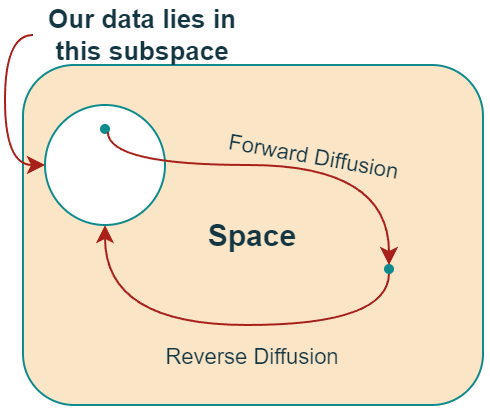

Image Source: https://learnopencv.com/denoising-diffusion-probabilistic-models/

In [ ]:
#@markdown <font color='#e59454'> <b> Question Time! Run to Show Question </b>

import random
from IPython.display import display, HTML

def create_quiz(question, correct_answers, decoy_answers):
    # Combine the correct answers with the decoy answers
    answers = correct_answers + decoy_answers
    # Shuffle the answers
    random.shuffle(answers)

    # Generate the HTML code
    html_code = f""" <div style="font-family: Arial, sans-serif; margin: 30px; max-width: 1000px;">
    <h3 style="word-wrap: break-word;">{question}</h3>"""

    # Add each answer as a checkbox
    for i, answer in enumerate(answers):
        html_code += f"""
        <div style="word-wrap: break-word; margin-bottom: 10px;">
        <input type="checkbox" id="option{i}" name="quiz" value="{answer}">
        <label for="option{i}" id="label{i}">{answer}</label>
        </div>"""

    # Add the submit button and feedback section
    html_code += f"""
    <button onclick="checkAnswers()">Submit</button>
    <p id="feedback" style="font-weight: bold;"></p>
    </div>
    <script>
    function checkAnswers() {{
        var checkboxes = document.getElementsByName('quiz');
        var correctAnswers = {str(correct_answers)};
        var feedback = document.getElementById('feedback');
        var numCorrect = 0;

        // Check each answer
        for (var i = 0, length = checkboxes.length; i < length; i++) {{
            var checkbox = checkboxes[i];
            var label = document.getElementById('label' + i);

            if (correctAnswers.includes(checkbox.value)) {{
                if (checkbox.checked) {{
                  if (numCorrect >= 0) {{
                    numCorrect++;
                  }}
                    label.style.color = "green";
                }} else {{
                    //label.style.color = "red";
                }}
            }} else if (checkbox.checked) {{
                numCorrect = -9999;
                label.style.color = "red";
            }} else {{
                //label.style.color = "inherit";
            }}
        }}

        // Provide feedback
        if (numCorrect === {len(correct_answers)}) {{
            feedback.innerHTML = "Correct! Only the reverse process requires a neural network. <br> Since the forward process makes the data noisy, we can use a predefined algorithm to implement the noising!";
            feedback.style.color = "green";
        }} else {{
            feedback.innerHTML = "Incorrect. Only the reverse process requires a neural network. <br> Since the forward process makes the data noisy, we can use a predefined algorithm to implement the noising!";
            feedback.style.color = "red";
        }}
    }}
    </script>"""

    display(HTML(html_code))

# Example
question = "At which step is the neural network used? Select all the correct answers."
correct_answers = ["Reverse Process"]
decoy_answers = ["Forward Process"]
create_quiz(question, correct_answers, decoy_answers)

Let us explore the forward and reverse processes in detail.

Run the following cell to load the standard packages for neural networks and activate the GPU (if available).


In [ ]:
#Run this cell to load the standard packages for neural networks
import random, math
from tqdm import tqdm # fun package to display a status bar during time consuming loops
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(0);
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **<font color='#569098'> Section 1: Forward Process </font>**

The forward process, described by distribution $q$, gradually adds noise to the data. It does so over a number of timesteps until the data is transformed into pure Gaussian noise. Taking the example of an image, we start with a real image $x_0$ at $t = 0$ and at every timestep $t$ add some noise to the image at the previous time step. The noise is typically sampled from a from a Gaussian distribution with a zero mean and unit standard deviation. Thus,

$$x_t = x_{t-1} + \text{noise}$$.

The forward process can be visualized like this: <br>
<img src = "https://erdem.pl/static/eb1c5091b8115b21499e408a8edf7b82/0f98f/cos_noise.jpg" width ="2000px">
Image Source: Step by Step visual introduction to Diffusion Models [https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models]

To understand the diffusion process we wil build a simple model from standard PyTorch parts. Let's make a one dimensional dataset of sine waves that we will noise and denoise.

Each sine wave is created by randomly sampling a phase, frequency, and amplitude. We sample a set of 32 points (input_size), with 64 sine waves in each batch (batch_size). As a simplest possible case, we've set the weight variable for frequency and amplitude to 0.

Feel free to play with these variables in subsequent rounds through this notebook.

In [ ]:
input_size = 32
batch_size = 64

historical_total_loss = []

class SineFunctionDataSet(Dataset):
  def __init__(self, size):
    super().__init__()
    self.input_size = input_size
    data = []

    for i in range(size):
      phase = 10*random.random() * 2.0 * 3.15 * 10
      freq = 14 + 0 * random.random()
      amplitude = 1 + 0*random.random()

      # equation for the sin wave: y = amplitude * sin( x * frequency / input_size + phase)
      data.append( torch.Tensor([ amplitude * math.sin(t_sin*freq/input_size + phase) for t_sin in range(input_size) ] ))

    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, i):
    return self.data[i]

sine_data = SineFunctionDataSet(1024*8)
data_loader = DataLoader(sine_data, batch_size = batch_size, drop_last=True)

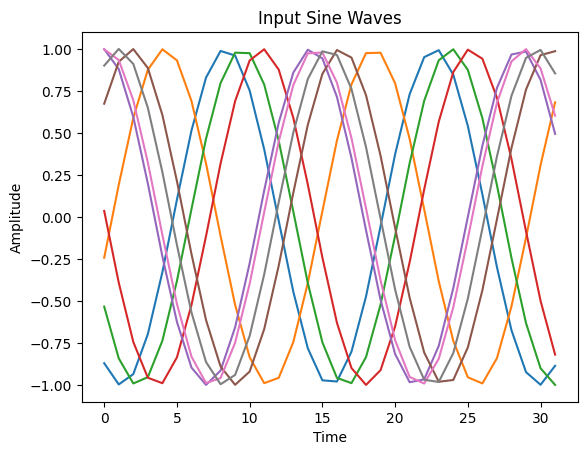

In [ ]:
#visualizing the data
for i in sine_data[0:8]:
  plt.plot(i)
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.title("Input Sine Waves")

We can sample from this distribution to get a data sample, $x_0$

We define the forward process $q$, that takes the data $x_{t-1}$ at timestep $t-1$ as input and produces the sample at the next timestep $t$ by adding  Gaussian noise. For the first timestep, $q_{t_0} \sim x_0$ The amount(or weight) of noise to be added follows a variance schedule $\beta_t$.

Thus, the forward process is defined as:
$$q(x_t | x_{t-1}) = \mathcal{N}(x_t ; \sqrt{1-\beta_t}x_{t-1},\beta_t \bf{I}),$$

where $\mathcal{N}$ is a normal distribution (aka a Gaussian distribution), defined by two parameters: a mean $\mu_t = \sqrt{1-\beta_t}x_{t-1}$ and a variance $\sigma^2 = \beta_t$.

The equation can be reparameterized as
$$q(x_t | x_{t-1}) = \sqrt{1-\beta_t}x_{t-1} + \sqrt{\beta_t} \mathcal{E},$$
where $\mathcal{E}\in\mathcal{N}(0,1)$.

In [ ]:
#@markdown <font color='#e59454'> <b> Question Time! Run to Show Question </b>

import random
from IPython.display import display, HTML

def create_quiz(question, correct_answers, decoy_answers):
    # Combine the correct answers with the decoy answers
    answers = correct_answers + decoy_answers
    # Shuffle the answers
    random.shuffle(answers)

    # Generate the HTML code
    html_code = f""" <div style="font-family: Arial, sans-serif; margin: 30px; max-width: 1000px;">
    <h3 style="word-wrap: break-word;">{question}</h3>"""

    # Add each answer as a checkbox
    for i, answer in enumerate(answers):
        html_code += f"""
        <div style="word-wrap: break-word; margin-bottom: 10px;">
        <input type="checkbox" id="option{i}" name="quiz" value="{answer}">
        <label for="option{i}" id="label{i}">{answer}</label>
        </div>"""

    # Add the submit button and feedback section
    html_code += f"""
    <button onclick="checkAnswers()">Submit</button>
    <p id="feedback" style="font-weight: bold;"></p>
    </div>
    <script>
    function checkAnswers() {{
        var checkboxes = document.getElementsByName('quiz');
        var correctAnswers = {str(correct_answers)};
        var feedback = document.getElementById('feedback');
        var numCorrect = 0;

        // Check each answer
        for (var i = 0, length = checkboxes.length; i < length; i++) {{
            var checkbox = checkboxes[i];
            var label = document.getElementById('label' + i);

            if (correctAnswers.includes(checkbox.value)) {{
                if (checkbox.checked) {{
                  if (numCorrect >= 0) {{
                    numCorrect++;
                  }}
                    label.style.color = "green";
                }} else {{
                    //label.style.color = "red";
                }}
            }} else if (checkbox.checked) {{
                numCorrect = -9999;
                label.style.color = "red";
            }} else {{
                //label.style.color = "inherit";
            }}
        }}

        // Provide feedback
        if (numCorrect === {len(correct_answers)}) {{
            feedback.textContent = "Correct!";
            feedback.style.color = "green";
        }} else {{
            feedback.innerHTML = "Incorrect <br> Since we are adding noise at every timestep, the final output is Gaussian Noise!";
            feedback.style.color = "red";
        }}
    }}
    </script>"""

    display(HTML(html_code))

# Example
question = "What is the final output of the forward diffusion process?"
correct_answers = ["Gausian Noise"]
decoy_answers = ["Denoised Data", "Randomized Inputs", "Original Features"]
create_quiz(question, correct_answers, decoy_answers)


We start from $x_0$, and produce $x_1$, ..., $x_t$, ..., $x_T$, where $x_T$ is pure Gaussian noise. We need a schedule $\beta_t$ to control how much noise is added. Typically, $\beta_t$ increases with every time step such that progressively more noise is added through the process:

$$0 < \beta_1 < \beta_2 < ... < \beta_T < 1$$

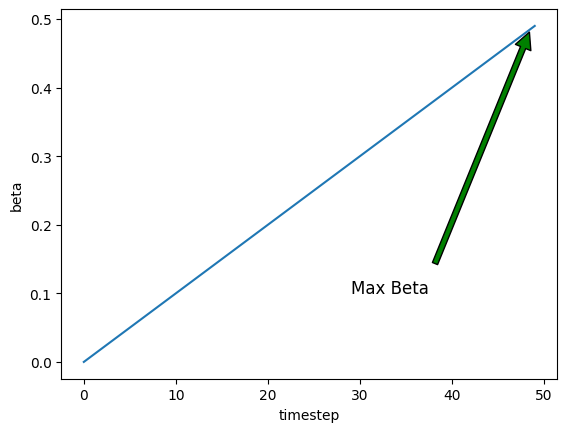

In [ ]:
#@markdown A simple example of a noise schedule is a linear function with increasing $\beta$s

#@markdown The max value of $\beta$ is limited to keep the variance from exploding
betas = torch.arange(0, .5, 0.01)
plt.plot(betas)
plt.xlabel("timestep")
plt.ylabel("beta")

plt.annotate('Max Beta', xy=(49, 0.5), xytext=(29, 0.1), fontsize=12,
            arrowprops=dict(facecolor='green', shrink=0.05));

In [ ]:
#@markdown <font color='#e59454'> <b> Food For Thought! Run to Show Question </b>

from IPython.display import HTML, display
from ipywidgets import widgets

def create_answer_box(question, correct_answer):
    def display_answer(button):
        user_answer = text_area.value.strip()
        result.value = f"<pre class='answer-text'>{correct_answer}</pre>"

    text_area = widgets.Textarea(
        placeholder='Enter your answer here...',
        layout={'width': '95%', 'height': '100px'}
    )
    submit_button = widgets.Button(description="Submit")
    result = widgets.HTML(value="")

    vbox = widgets.VBox([text_area, submit_button, result])
    submit_button.on_click(display_answer)

    display(HTML(f"<b>{question}</b>"))
    display(vbox)
    display(HTML("""
    <style>
    .widget-html-content {
        width: 95%;
        white-space: normal;
        word-wrap: break-word;
    }
    .answer-text {
        width: 90%;
        color: black;
        line-height: 1.5;
        white-space: pre-wrap;
        word-wrap: break-word;
        font-family: inherit;
        font-size: inherit;
        margin: 0;
        padding: 0;
    }
    </style>
    """))

# Example usage
create_answer_box("What is the problem with an exploding gradient?", "Recall how a neural network is trained: "
                  "at the end of the forward pass the derivatives are "
                  "backpropagated and used to update the model weight. When the variance "
                  "is too high these derivatives dominate the model weights, making "
                  "it difficult to converge to a minimum during gradient descent."
                  "Refresh the concepts from one of the earlier notebooks if this difficult to follow")

However, researchers from OpenAI in 2021 found that a linear schedule is not the most efficient. When using a linear schedule, most of the original image is lost after around half of the total steps. The remaining data is not very useful to learn from. To overcome this drawback and utilize the training time effectively, researchers designed custom schedules with slower addition of noise. One such useful schedule is a cosine schedule. From the image below we observe that the cosine schedule on the bottom preserves more information in the earlier timesteps while adding greater noise in the later timesteps:

<img src = 'https://cdn.analyticsvidhya.com/wp-content/uploads/2024/07/Screenshot-from-2024-07-24-14-14-44.png' width = 1000 px>

Visualization of different schedules.
**Top Panel:** Linear Schedule **Bottom Panel:** Cosine Schedule

Image Source: Improved Denoising Diffusion Probabilistic Models, Alex Nichol, Prafulla Dhariwal 2021


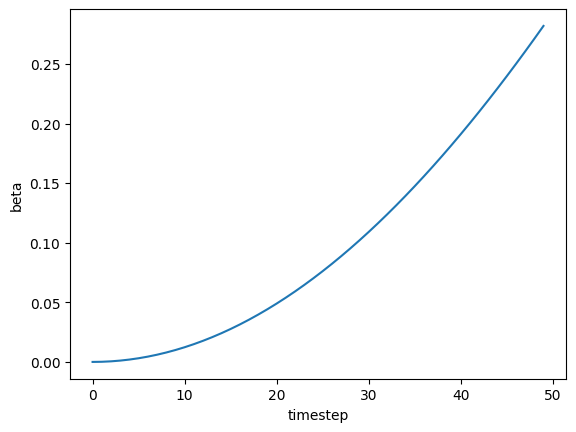

In [ ]:
# Cosine schedule
betas_linear = torch.arange(0, .5, 0.01)
betas = 1 - ( betas_linear * torch.pi / 2 ).cos()
plt.plot(betas);
plt.xlabel("timestep");
plt.ylabel("beta");

As described above, the forward diffusion process starts at $t_0$ and moves sequentially to time $t_T$ because the sample at each timestep depends on the previous one.  Adding noise step by step is expensive. To make the process faster, the we can convolute the effect of multiple steps to produce one formula that defines the output at any desired timestep ([details here](https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models#:~:text=But%202020%20paper%20has%20the%20solution%2C%20but%20first%2C%20we%20have%20to%20define%20the%20entire%20noise%20to%20be%20added%20at%20T%20as%3A)).

$$q(x_t | x_0) = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}} \mathcal{E}$$
where
$$\alpha_t = 1 - \beta_t$$
$$\bar{\alpha}_t := Π^t_{s=1} a_s$$.

Let's calculate and store the $\alpha$ values:

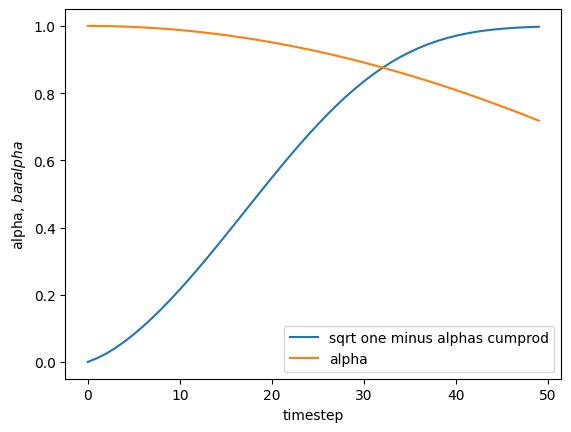

In [ ]:
alphas = torch.Tensor( [1.0 - b for b in betas] )
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# let's also store our previous alphas, which will come in use later
alphas_prev = F.pad(alphas[:-1], (1, 0), value=1.0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

plt.plot(sqrt_one_minus_alphas_cumprod, label = 'sqrt one minus alphas cumprod')
plt.plot(alphas, label ='alpha')
plt.xlabel("timestep");
plt.ylabel(r"alpha, $bar{alpha}$");
plt.legend();

Now we have our various constants. Next let's make a function to add noise to data at some timestep $t$

In [ ]:
def noised_data(x0, t, noise=None):
	if noise is None: noise = torch.randn_like(x0)

	alpha_t = alphas_cumprod[t]

	x = x0 * torch.sqrt(alpha_t) + torch.sqrt(1.0 - alpha_t) * noise

	return x, noise

Let's examine an example of adding noise to a sine wave, where the image evolves through the diffusion process, gradually becoming noisier as the variance decreases over time according to the specified schedule.

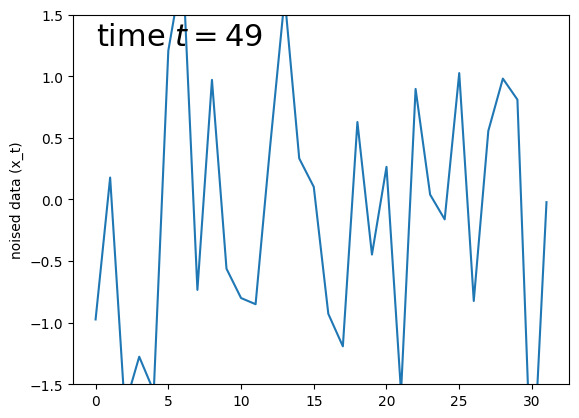

In [ ]:
import time
import pylab as pl
from IPython.display import display, clear_output

example = next(iter(data_loader))
for i in range(len(betas)):
  plt.clf()
  plt.plot( noised_data(example, i)[0][0] )
  plt.ylabel("noised data (x_t)")
  plt.ylim(-1.5,1.5)
  plt.text(0, 1.25, 'time $t = $'+str(i), fontsize = 22)
  display(pl.gcf())
  clear_output(wait=True)
  time.sleep(0.04)

In [ ]:
#@markdown <font color='#e59454'> <b> Run to Show Question </b>

create_answer_box('Can we have a constant variance schedule? How will it impact the forward process?',
                  'Yes we can! But it would make the noise uniform and suboptimally utilze the learning capacity of the model. The choice of variance schedule is important in deciding the performance of the model.')


In [ ]:
#@markdown <font color='#e59454'> <b> This is a trickier question but give it a try! Run to Show Question </b>

from IPython.display import HTML, display
from ipywidgets import widgets

def create_answer_box(question, correct_answer):
    # Function to display the answer when the button is clicked
    def display_answer(button):
        user_answer = text_area.value.strip()
        result.value = f"<pre class='answer-text'>{correct_answer}</pre>"
        display(HTML(mathjax_script))  # Refresh MathJax to render equations

    # Create a text area for user input
    text_area = widgets.Textarea(
        placeholder='Enter your answer here...',
        layout={'width': '95%', 'height': '100px'}
    )

    # Create a submit button
    submit_button = widgets.Button(description="Submit")

    # Create an HTML widget to display the correct answer
    result = widgets.HTML(value="")

    # Create a vertical box layout for the text area, button, and result
    vbox = widgets.VBox([text_area, submit_button, result])

    # Bind the button click event to the display_answer function
    submit_button.on_click(display_answer)

    # Display the question with LaTeX support using MathJax
    mathjax_script = """
    <script type="text/javascript" async
      src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
      </script>"""

    # Display the question and widgets
    display(HTML(mathjax_script))
    display(HTML(f"<b>{question}</b>"))
    display(vbox)

    # Add custom styling for the output box
    display(HTML("""
    <style>
    .widget-html-content {
        width: 95%;
        white-space: normal;
        word-wrap: break-word;
    }
    .answer-text {
        width: 90%;
        color: black;
        line-height: 1.5;
        white-space: pre-wrap;
        word-wrap: break-word;
        font-family: inherit;
        font-size: inherit;
        margin: 0;
        padding: 0;
    }
    </style>
    """))

# Example usage with LaTeX equations in both question and correct answer
question = r"Here is the forward process equation: $$q(x_t | x_{t-1}) = \mathcal{N}(x_t ; \sqrt{1-\beta_t}x_{t-1},\beta_t \mathbf{I})$$ Why do we add a weighing term to the mean?"

# Correct answer with LaTeX for \beta and other symbols
correct_answer = r"""By weighing the x_t term we reduce the contribution of the original signal gradually, ensuring that the final output of the forward process is nearly Gaussian noise. To visualize this, consider a one-dimensional data distribution consisting of a waveform with multiple peaks, as shown below. The goal of the forward process is to destroy the data and convert it to a normal distribution with a single peak (mean) at 0 and unit variance.
<img src='https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models_forward_process_changing_distribution.png' width='400px'>
Image Source: https://ayandas.me/blog-tut/2021/12/04/diffusion-prob-models.html
"""
create_answer_box(question, correct_answer)


# **<font color='#569098'>Section 2: Reverse Process </font>**##

In the reverse process the model learns to generate the original image from the noised version of it.

<font color='#e59454'> *Extra geeky detail: While we want the model to generate data that resembles the training data, we do not aim for exact replicas. Instead, the goal is to ensure that the generated data belongs to the same distribution as the original images. For example, if the model is trained on images of yellow sunflowers, it should be capable of generating sunflowers with different shades of yellow, introducing natural variations rather than reproducing a single, fixed hue. This ensures that the model captures the diversity within the data distribution, rather than simply memorizing individual data points.* </font>

If we knew the conditional distribution $p(x_{t-1}|x_t)$, ie, if we knew the dependence of the less noisy image $x_{t-1}$ on the noisier image $x_t$ then we could run the process in reverse by sampling from some Gaussian noise $x_T$ and then gradually denoising it so that we end up with a sample from a real distribution $x_0$.

However, we don't know $p(x_{t-1}|x_t)$. It's intractable since we would need to know the distribution of all possible $x_{t-1}$ that could result in a particular $x_t$ to calculate this conditional probability. Hence, we're going to use a neural network to predicts the conditional distribution $p(x_0|x_t)$.

The model's prediction is represented by $p_\theta (x_{t-1}|x_t)$, with $\theta$ being the parameters of the neural network, updated by gradient descent. For each step, the functional form that is typically chosen is a Gaussian:

$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1} ; \mu_\theta (x_t, t),\sigma^2_\theta(x_t, t ))$$

where the mean and variance are also conditioned on the noise level, $t$. In this way, our network now needs to predict these parameters for the Gaussian distribution, $\mu$ and $\sigma$.

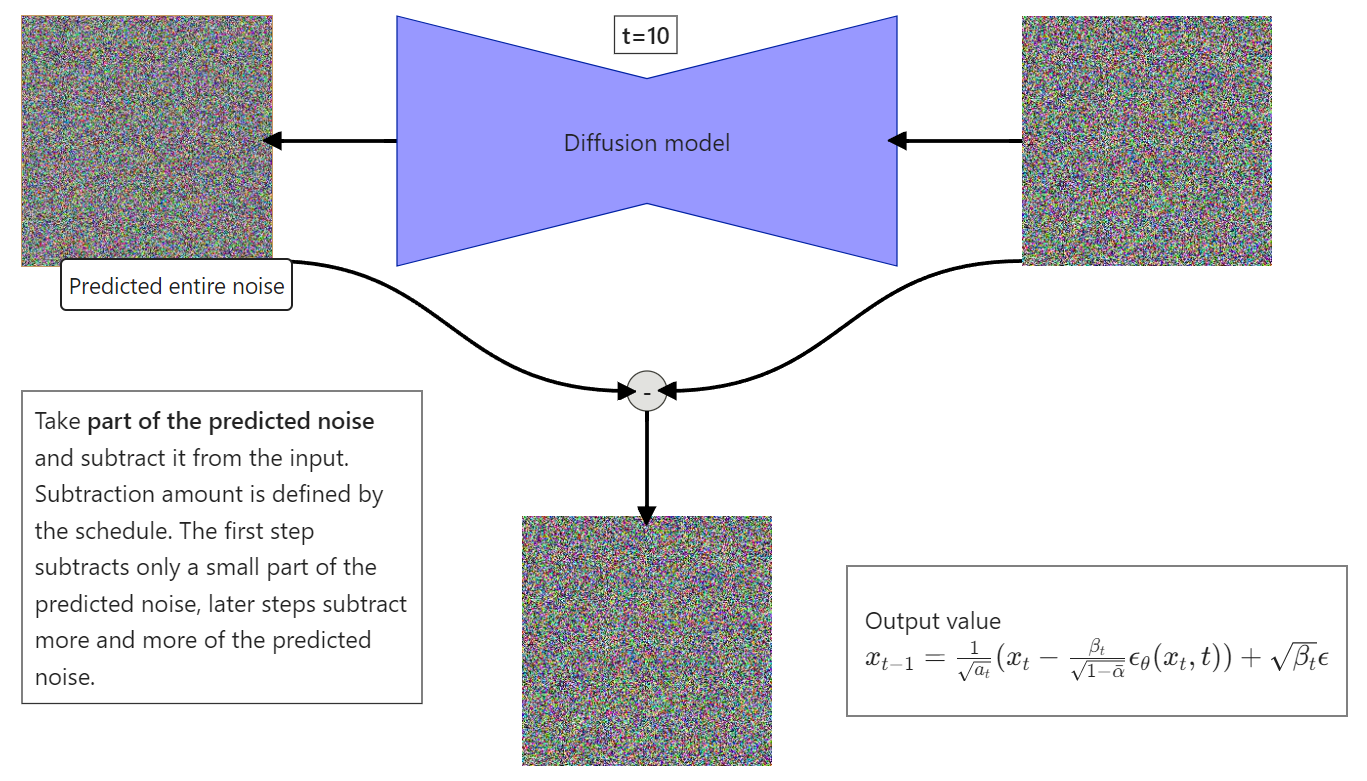

Image Source: https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models

<b><h1> <font color='#569098'> THE LOSS TERM </font></h1></b>

At every time step, the difference between the noised image and the predicted image defines the added noise.

The total loss of the model is a sum of the losses at every time step:

$$L = L_0 + L_1 + L_2 + L_3 + L_4 ...  + L_T$$

We can ignore the $L_T$ loss because at that timestep there are no neural network parameters to be learnt and the best we can do is define a good variance scheduler and use appropriately sized timesteps.

Empirically, the authors of the [denoising diffusion probabilistic models](https://arxiv.org/abs/2006.11239) paper found that the model performed better without the $L_0$ term, so it is often ignored during training.

Then can use the Kullback–Leibler divergence to estimate $L_t$ which is just measuring the difference between the original probability distribution and the predicted distribution.

$$ D_{KL}(q(x_t| x_0) ∥ p_θ(x_t| x_t−1)) = - ELBO + log(p_θ(x_0| x_t)) $$

We want to minimize $D_{KL}$ and the conditional probabilty is a constant So the only term we can use for training is the ELBO. The Evidence Lower Bound (ELBO) combines the reconstruction loss with a regularization term that encourages the model to learn a smooth, continuous distribution.

Maximizing ELBO (thus minimizing $D_{KL}$) ensures that the model not only fits the data well but also generalizes effectively to new data.

Instead of predicting the original probability distribution at each time step we can instead predict just the noise by reparameterizing the $p_θ$ equation

$$x_{t-1}  = \mathcal{N}(x_{t-1} ; \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}}\mathcal{E_\theta}(x_t, t)), \sqrt{\beta_t}\mathcal{E})$$

Learn more about variational inference at: https://gregorygundersen.com/blog/2021/04/16/variational-inference/

We went through a lot of new concepts but the key takeaway is that the model is trained to predict the noise at each step and the final loss term that we use for training is an Mean Squared Error (MSE) between the noise added in the forward process and the noise predicted by the model.

<img src= "https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-loss_equations_10.png" width = 300>


In [ ]:
# @markdown <font color='#e59454'> <b> Run the cell for the question</b></font>
def create_quiz(question, correct_answers, decoy_answers):
    # Combine the correct answers with the decoy answers
    answers = correct_answers + decoy_answers
    # Shuffle the answers
    random.shuffle(answers)

    # Generate the HTML code
    html_code = f""" <div style="font-family: Arial, sans-serif; margin: 30px; max-width: 1000px;">
    <h3 style="word-wrap: break-word;">{question}</h3>"""

    # Add each answer as a checkbox
    for i, answer in enumerate(answers):
        html_code += f"""
        <div style="word-wrap: break-word; margin-bottom: 10px;">
        <input type="checkbox" id="option{i}" name="quiz" value="{answer}">
        <label for="option{i}" id="label{i}">{answer}</label>
        </div>"""

    # Add the submit button and feedback section
    html_code += f"""
    <button onclick="checkAnswers()">Submit</button>
    <p id="feedback" style="font-weight: bold;"></p>
    </div>
    <script>
    function checkAnswers() {{
        var checkboxes = document.getElementsByName('quiz');
        var correctAnswers = {str(correct_answers)};
        var feedback = document.getElementById('feedback');
        var numCorrect = 0;

        // Check each answer
        for (var i = 0, length = checkboxes.length; i < length; i++) {{
            var checkbox = checkboxes[i];
            var label = document.getElementById('label' + i);

            if (correctAnswers.includes(checkbox.value)) {{
                if (checkbox.checked) {{
                  if (numCorrect >= 0) {{
                    numCorrect++;
                  }}
                    label.style.color = "green";
                }} else {{
                    //label.style.color = "red";
                }}
            }} else if (checkbox.checked) {{
                numCorrect = -9999;
                label.style.color = "red";
            }} else {{
                //label.style.color = "inherit";
            }}
        }}

        // Provide feedback
        if (numCorrect === {len(correct_answers)}) {{
            feedback.innerHTML = "Correct! <br>  As discussed in the above section, at each step the model predicts the noise which has to be removed to obtain the original data";
            feedback.style.color = "green";
        }} else {{
            feedback.innerHTML = "Incorrect. <br> As discussed in the above section, at each step the model predicts the noise which has to be removed to obtain the original data";
            feedback.style.color = "red";
        }}
    }}
    </script>"""

    display(HTML(html_code))
question = "What is the model trained to predict at each time step?"
correct_answers = ["Noise Added to the Data"]
decoy_answers = ["Conditional Probability", "Randomized Probability Distribution", "Original Data"]
create_quiz(question, correct_answers, decoy_answers)

In [ ]:
# @markdown <font color='#e59454'> <b> Run the cell for the question</b></font>
def create_quiz(question, correct_answers, decoy_answers):
    # Combine the correct answers with the decoy answers
    answers = correct_answers + decoy_answers
    # Shuffle the answers
    random.shuffle(answers)

    # Generate the HTML code
    html_code = f""" <div style="font-family: Arial, sans-serif; margin: 30px; max-width: 1000px;">
    <h3 style="word-wrap: break-word;">{question}</h3>"""

    # Add each answer as a checkbox
    for i, answer in enumerate(answers):
        html_code += f"""
        <div style="word-wrap: break-word; margin-bottom: 10px;">
        <input type="checkbox" id="option{i}" name="quiz" value="{answer}">
        <label for="option{i}" id="label{i}">{answer}</label>
        </div>"""

    # Add the submit button and feedback section
    html_code += f"""
    <button onclick="checkAnswers()">Submit</button>
    <p id="feedback" style="font-weight: bold;"></p>
    </div>
    <script>
    function checkAnswers() {{
        var checkboxes = document.getElementsByName('quiz');
        var correctAnswers = {str(correct_answers)};
        var feedback = document.getElementById('feedback');
        var numCorrect = 0;

        // Check each answer
        for (var i = 0, length = checkboxes.length; i < length; i++) {{
            var checkbox = checkboxes[i];
            var label = document.getElementById('label' + i);

            if (correctAnswers.includes(checkbox.value)) {{
                if (checkbox.checked) {{
                  if (numCorrect >= 0) {{
                    numCorrect++;
                  }}
                    label.style.color = "green";
                }} else {{
                    //label.style.color = "red";
                }}
            }} else if (checkbox.checked) {{
                numCorrect = -9999;
                label.style.color = "red";
            }} else {{
                //label.style.color = "inherit";
            }}
        }}

        // Provide feedback
        if (numCorrect === {len(correct_answers)}) {{
            feedback.innerHTML = "Correct!";
            feedback.style.color = "green";
        }} else {{
            feedback.innerHTML = "Incorrect.";
            feedback.style.color = "red";
        }}
    }}
    </script>"""

    display(HTML(html_code))
question = "What is the final objective used to guide model training?"
correct_answers = ["Minimize the difference between predicted and original distribution"]
decoy_answers = ["Predict the conditional probability", "Maximize the difference between predicted and original distribution"]
create_quiz(question, correct_answers, decoy_answers)

# **<font color='#569098'> Section 3: DDPM Implementation (MODEL ARCHITECTURE) </font>**

### <b><h3><font color='#569098'> 1. TIME EMBEDDINGS  </font></b></h3>


As mentioned earlier, the model can learn from all the timesteps of a particular sample without going sequentially. Yet it is important for the model to know which timestep the data belongs to. To implement this, we define the `SinusoidalTimeEmbeddings` class. The Time embeddings class converts the timestep (in number) to a vector in latent space of the same dimension as the data. At each block of the MLP, these embeddings are added to the model.  This is similar to the self attention embeddings in the "Attention is All You Need" paper (Vaswani et al., 2017). The embeddings allow the neural network "know" at which particular time step (noise level) it is operating, for every image in a batch.

The forward method takes a tensor representing the time (noise levels of several noisy images in a batch) as input and outputs Time embeddings of shape (batch_size, dim). The Time embeddings are computed using sinusoidal functions and concatenated together to form the final embeddings.

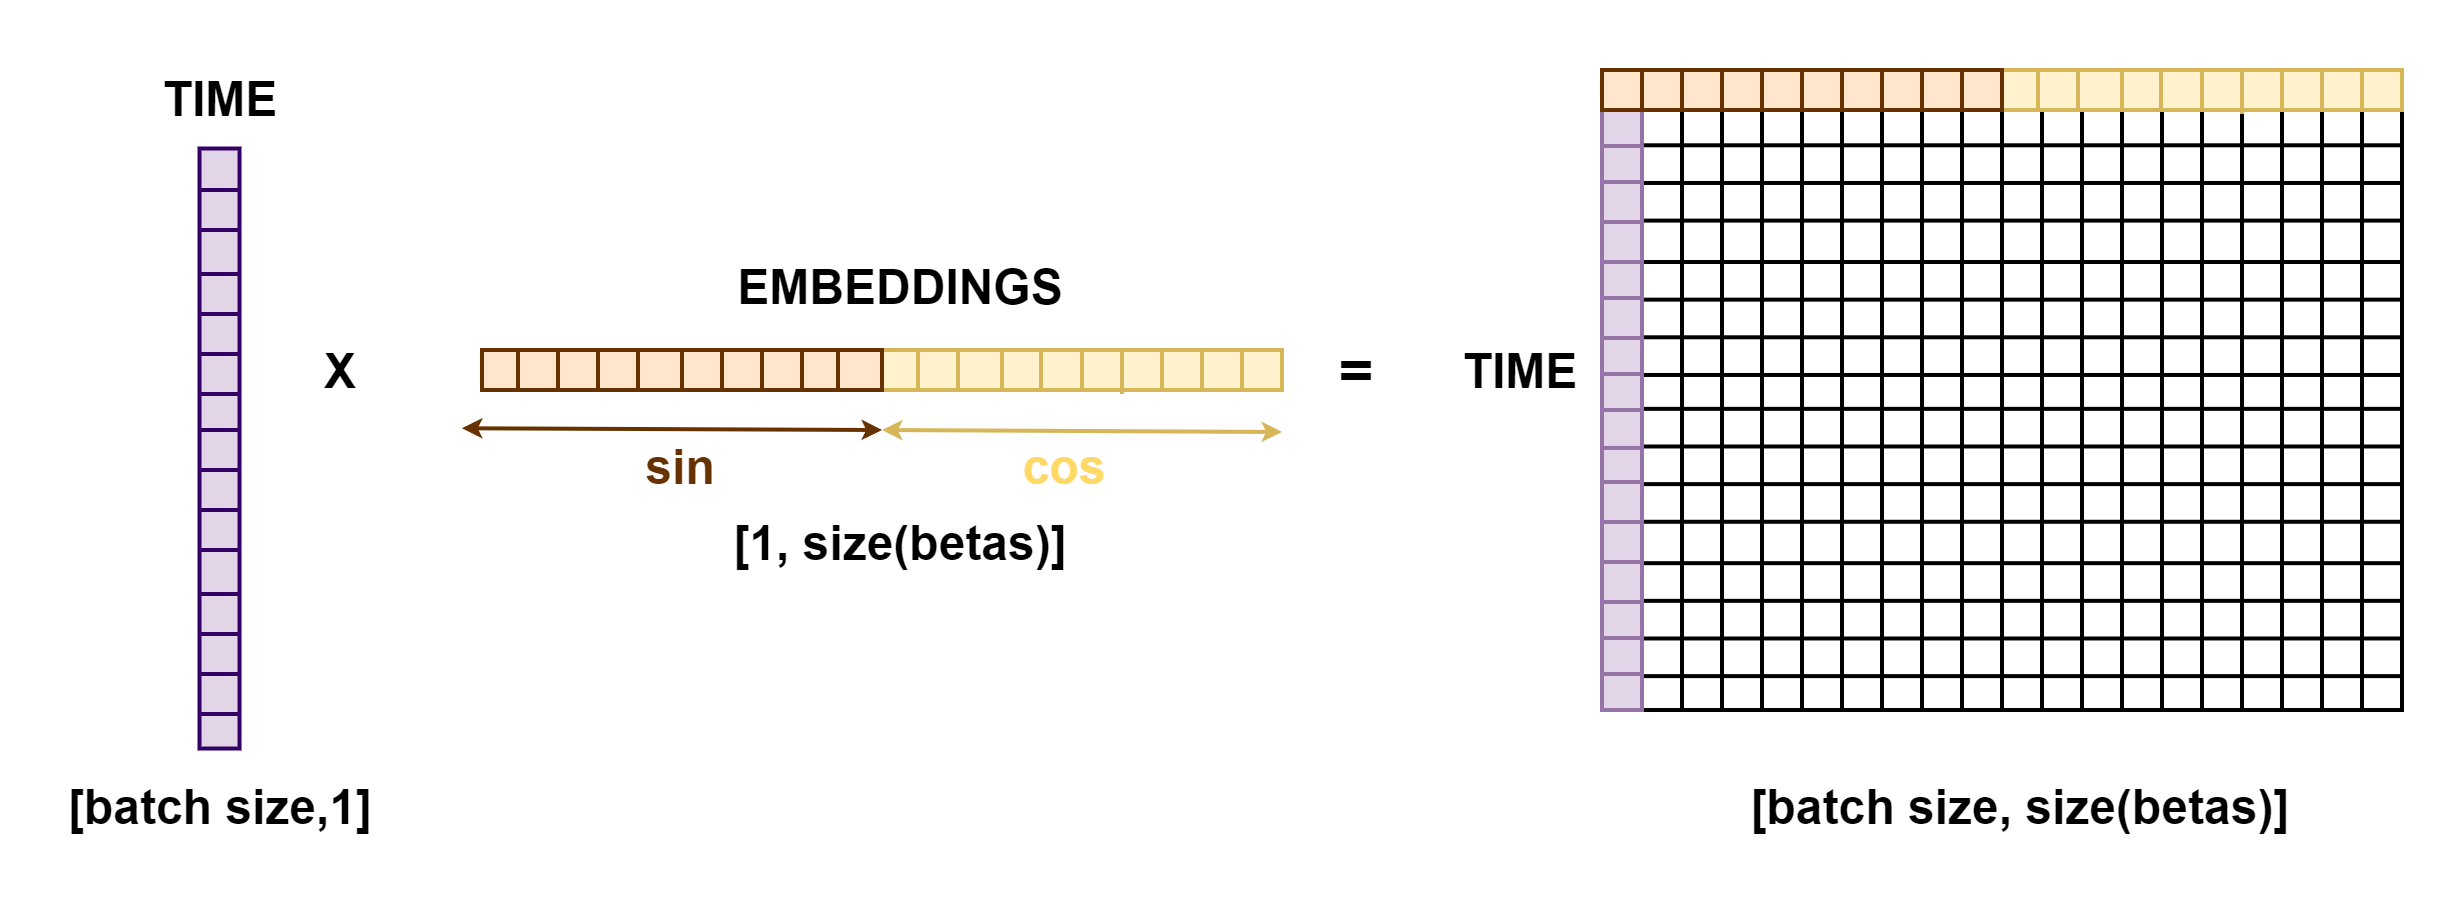

In [ ]:
# The SinusoidalTimeEmbeddings module takes a tensor of shape (batch_size, 1) i.e. (64,1)
# as input (i.e. the noise levels of several noisy images in a batch), and turns this
# into a tensor of shape (batch_size, dim), with dim being the dimensionality of the
# Time embeddings. This is then added to each residual block, as we will see further.
class SinusoidalTimeEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        # half of embedding dim
        half_dim = self.dim // 2
        # scaling factor for sinusoidal Time embeddings
        embeddings = math.log(10000) / (half_dim - 1)
        # generate sinusoidal Time embeddings
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        # expand time tensor along second dimesion, multiply with embeddings
        embeddings = time[:, None] * embeddings[None, :]
        # concatenate sine and cosing embeddings along last dimension
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### <b><h3><font color='#569098'> 2. NEURAL NET </font></b></h3>

Now that we have our embeddings, we use a multi layer perceptron model for our simple dataset consisting of multiple deeply connected layers followed by activation functions.

`Diffuser_MLP` predicts the denoised data $x_0$ from the noised state $x_t$ at time $t$. It takes the input size (input_size), an activation function (fun) to be applied between layers, and a list of layer sizes (layers), and it returns an output the same size as the input.

The forward method takes an input tensor `x` and a `time tensor`, applies sinusoidal time embeddings to the time tensor, concatenates it with the input tensor, and feeds it through the MLP layers.


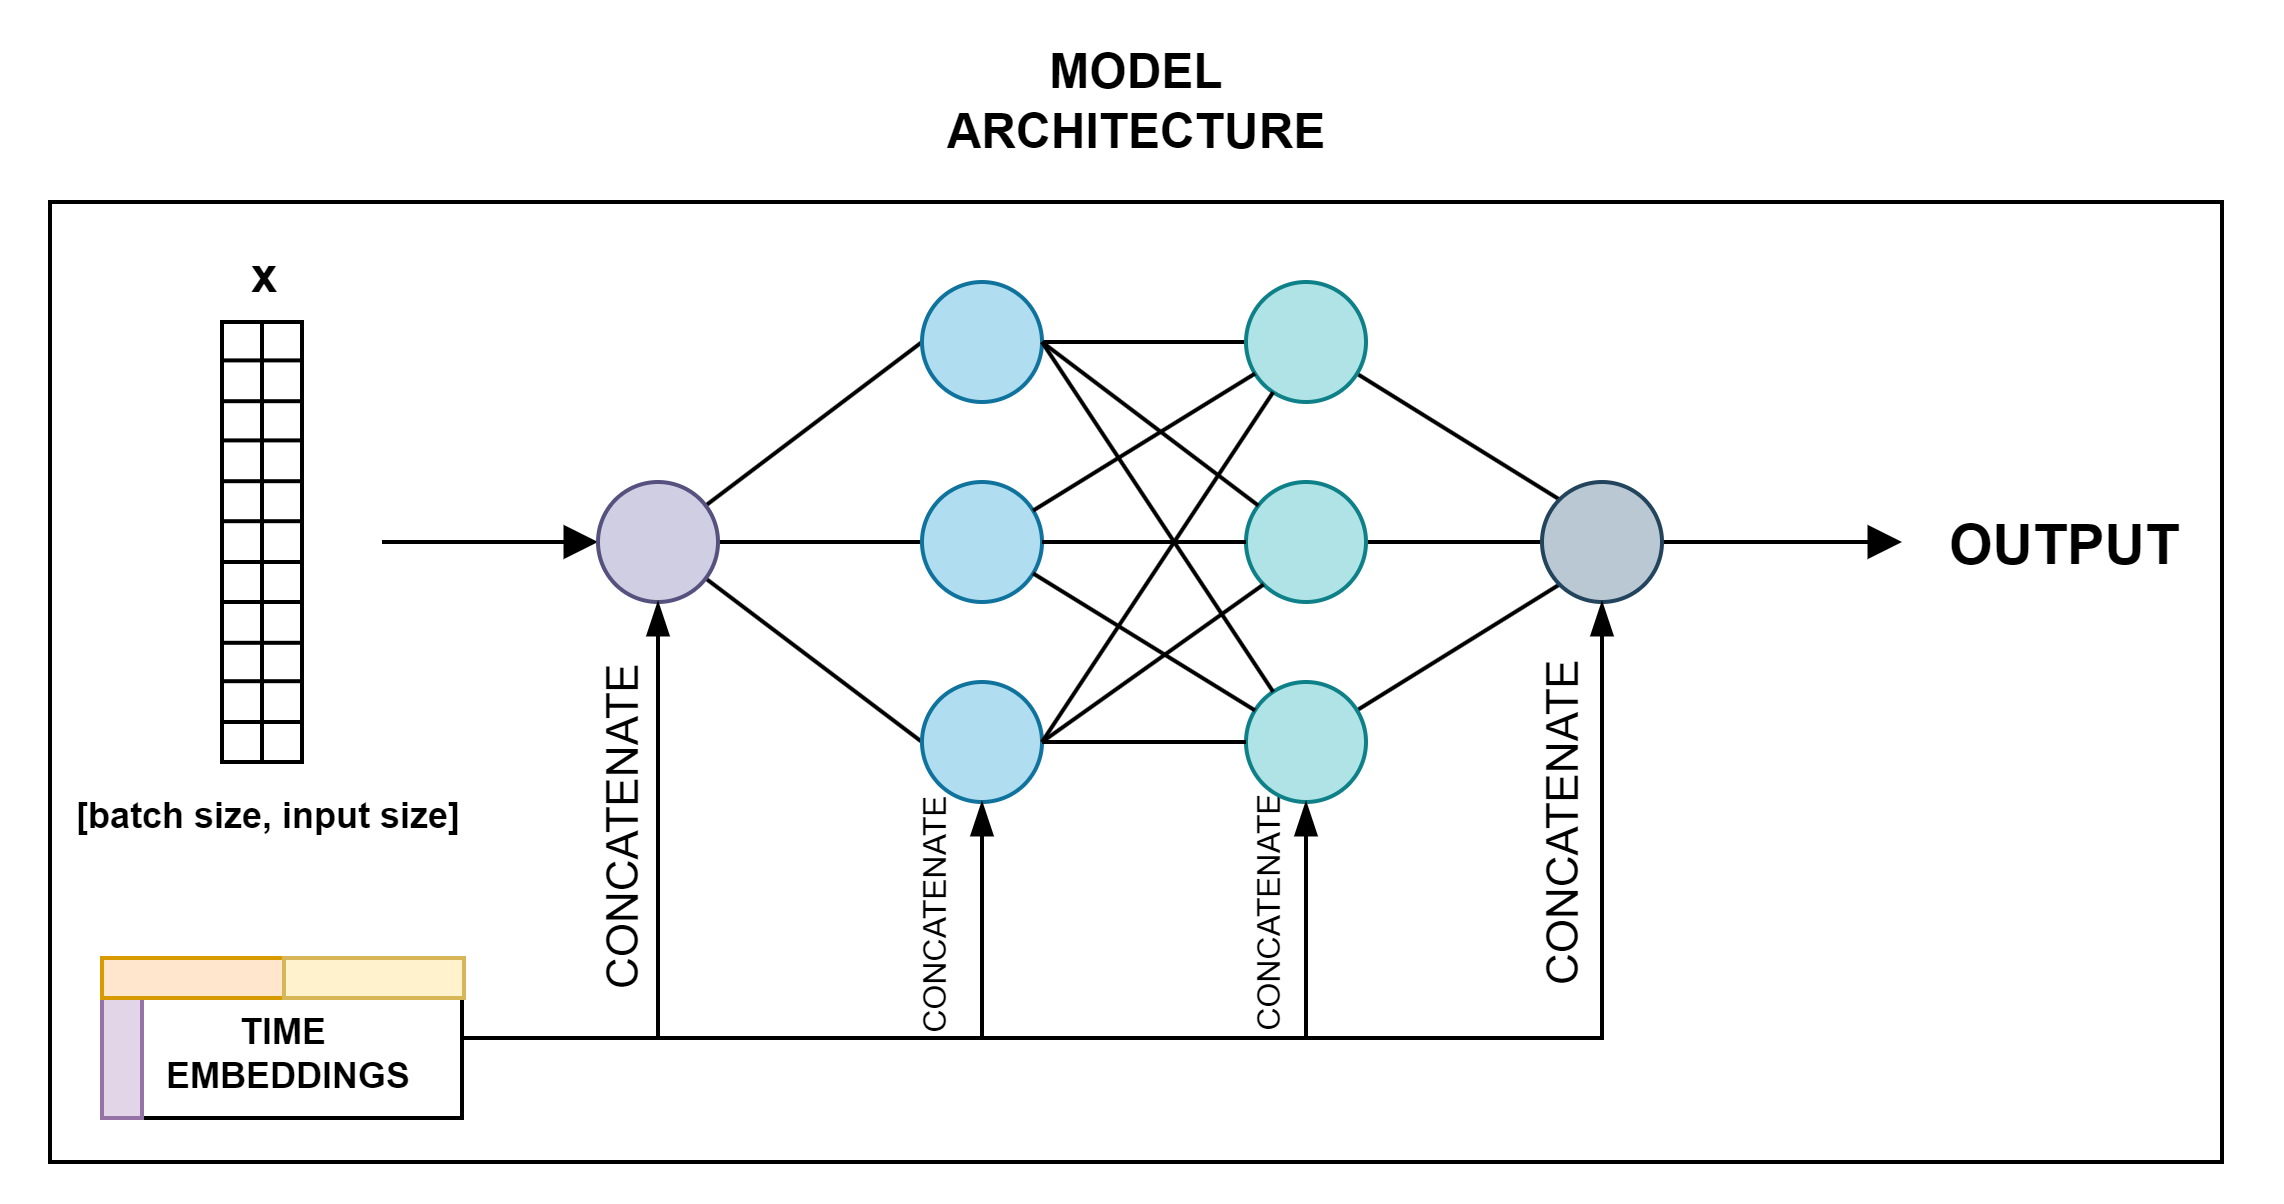

In [ ]:
class Diffuser_MLP(nn.Module):
  """this model learns to predict the denoised data x_0 from the noised state x_t and the time t"""
  def __init__(self, input_size, *, fun=None, layers=None):
    """fun is the activation function; layers is a list of integers, with the integer indicating the width of the embedding dimension as a factor of the input data size"""
    super().__init__()

    # dim of time embedding based on size of betas
    self.time_embedding_dim = math.ceil( math.log2(betas.shape[0]) ) * 2
    # initialize SinusoidalTimeEmbeddings
    self.time_embedding_nn = SinusoidalTimeEmbeddings(self.time_embedding_dim)
    # initialize sequential NN
    self.net = torch.nn.Sequential()

    # compute initial size of input to NN
    prev_size = input_size + self.time_embedding_dim
    # iterate through layers
    for l in layers:
      # compute layer size
      new_size = int(input_size*l)
      # add linear layer to NN
      self.net.append( torch.nn.Linear(prev_size, new_size) )
      # append activation function
      self.net.append( fun() )
      # update previous size for next layer
      prev_size = new_size

    # append linear layer to NN to map final size to input
    self.net.append( torch.nn.Linear(prev_size, input_size) )

  def forward(self, x, time):
    # compute time embedding for given time
    time_embedding = self.time_embedding_nn(time).squeeze(1)
    # concatenate input data with time embeddings
    x_t = torch.cat((x, time_embedding), -1)
    # pass concatenated data through NN
    output = self.net(x_t)
    return output

Let us instantiate our model, provide it with input data, compute the output of the model, and check that our data objects have the right shape.

In [ ]:
# instantiate
diff = Diffuser_MLP(input_size, fun=torch.nn.ReLU, layers=(3, 3) )

# example time tensor by expanding single value along batch dimension to match 'example' shape
example_time = torch.Tensor([0]).expand(example.shape[0], 1)

# pass exmaple data and exmaple_time through diffuser NN to get output
output = diff(example, example_time)

# shape of input data, example_time, and output tensor
example.shape, example_time.shape, output.shape

(torch.Size([64, 32]), torch.Size([64, 1]), torch.Size([64, 32]))

### <b><h3><font color='#569098'> 3. TRAINING </font></b></h3>

Time to train! Within each epoch, we will iterate through the data loader to process batches of data. For each batch, a random time step is chosen and noisy data is generated according to the cosine scheduler we defined earlier. The model processes this noisy input data along with the corresponding time information and computes the output. A mean squared error loss is then calculated between the model's output and the noisy data. Subsequently, gradients are zeroed, and a backward pass is executed to update the model's parameters using the optimizer. Throughout the training process, the total loss is accumulated for logging purposes, and the average loss per step is computed.

An Adam optimizer is employed to optimize the parameters of the diffusion model. An ExponentialLR scheduler is utilized to modulate the learning rate during training, providing adaptive adjustments to facilitate convergence. In the main training loop, the model is trained over multiple epochs, with each epoch comprising a series of training steps. Following each epoch's completion, the learning rate is updated using the scheduler.

last_losses=[0.1390904188156128, 0.11419769376516342, 0.12434312701225281, 0.12849435210227966]
mean_loss=0.12653139233589172


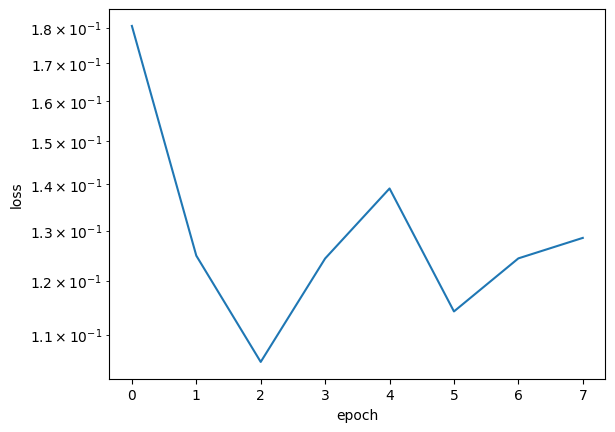

In [ ]:
def train(model, optimizer, *, n_steps):
    # Set the model in training mode
    model.train()

    # Define the loss function as Mean Squared Error
    loss_fn = nn.MSELoss()

    # Iterate through training steps
    for epoch in range(n_steps):
        total_loss = 0
        total_loss_count = 0

        # Iterate through data batches
        for batch in data_loader:
            # Randomly select a time
            t = random.randrange(0, betas.shape[0])

            # Generate noised data for the selected time step
            input, noise = noised_data(batch, t)

            # Pass the input data and time to the model to get the output
            output = model(input, torch.Tensor([t]).expand(input.shape[0], 1))

            # Compute the loss between the output and the noise
            loss = loss_fn(output, noise)

            # Compute the mean loss
            loss = loss.mean()

            # Reset gradients
            optimizer.zero_grad(set_to_none=True)

            # Perform backpropagation
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Accumulate total loss
            total_loss += loss
            total_loss_count += 1

    # Compute the total loss average over the training batch
    total_loss = total_loss / total_loss_count

    # Append the total loss to historical_total_loss list
    with torch.no_grad():
        historical_total_loss.append(total_loss.item())

    # Return the last historical total loss
    return historical_total_loss[-1]

# Initialize Adam optimizer for the Diffuser_MLP model parameters with learning rate 1e-3
optimizer = torch.optim.Adam(diff.parameters(), lr=1e-3)

# Initialize ExponentialLR scheduler for the optimizer with gamma 0.9
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Iterate training for 8 epochs
for i in range(8):
    # Perform training for 32 steps
    total_loss = train(diff, optimizer, n_steps=32)

    # Adjust learning rate using lr_scheduler
    lr_scheduler.step()

    # Clear previous plot and plot historical total losses
    pl.clf()
    plt.yscale('log')
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.plot(historical_total_loss[:])
    display(pl.gcf())

    # Calculate mean loss over the last 4 epochs
    mean_loss = torch.Tensor(historical_total_loss[-4:]).mean().item()

    # Extract the last 4 losses
    last_losses = historical_total_loss[-4:]

    # Print the last 4 losses and the mean loss
    print(f'{last_losses=}\n{mean_loss=}')

    # Clear output for the next iteration
    clear_output(wait=True)

# Print the last 4 losses and the mean loss after completing all epochs
print(f'{last_losses=}\n{mean_loss=}')


### <b><h3><font color='#569098'> 4. GENERATION </font></b></h3>

Now we can sample from a trained diffusion model to generate synthetic images. We will iteratively sample from the diffusion model in reverse order, starting from the final time step and progressing backward in time. Each sample is generated based on the model's mean output and optionally augmented with Gaussian noise.

There is one final concept needed to be understood before we can proceeed - **Posterior Variance**

During sampling phase, the goal is to generate new data from the learned model that resembles the training data. The posterior variance helps manage the uncertainty inherent in the data generation process and guides how much noise to add or remove at each step to achieve realistic and varied outputs.

For example a diffusion model that is used to generate images learns both the mean of the image distribution and the variance of the data. If the model only learns the mean of the image distribution but ignores the variance, it might generate images that are too similar to each other and lack diversity. By incorporating posterior variance, the model can generate a range of images with subtle differences, reflecting the true variability present in the dataset.

The posterior variance is given by the formula

<img src = 'https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-loss_equations_6.png' width ='1000px'>


where the $\bar{\mu_t}, \bar{\beta_t}$ depend on the cumulative products.

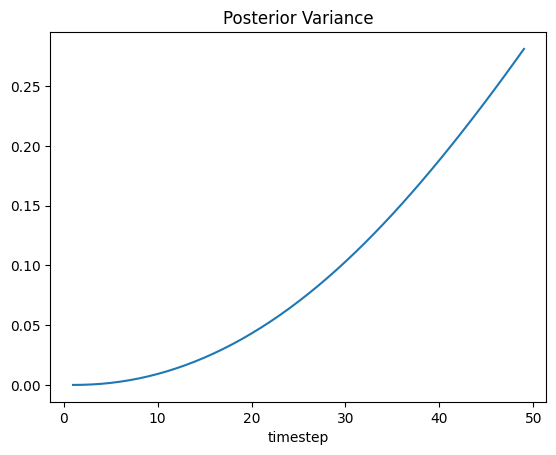

In [ ]:
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
plt.plot(posterior_variance)
plt.xlabel("timestep");
plt.title("Posterior Variance");

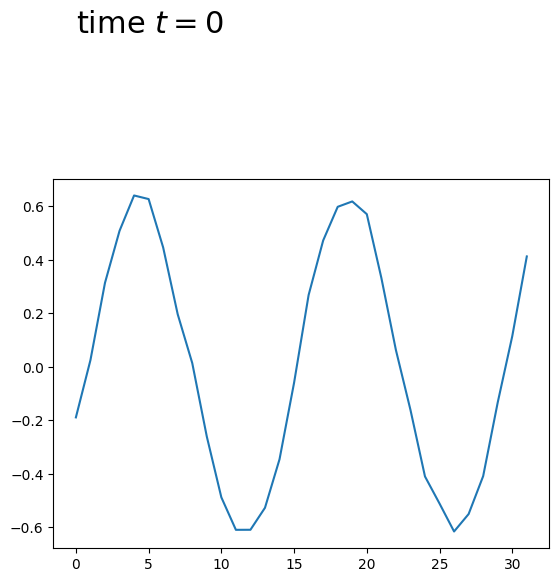

In [ ]:
# Decorator to temporarily disable gradient computation
@torch.no_grad()
def sample(model, x, t, t_index):
    # Extract necessary parameters for the current time step
    betas_t = betas[t]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
    sqrt_recip_alphas_t = sqrt_recip_alphas[t]

    # Compute the mean of the model's output
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    # If it's the first time step, return the model mean
    if t_index == 0:
        return model_mean
    else:
        # Extract posterior variance for the current time step
        posterior_variance_t = posterior_variance[t]

        # Generate Gaussian noise
        noise = torch.randn_like(x)

        # Return the sample by adding noise scaled by the square root of the posterior variance to the model mean
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Generate random input tensor 'x'
x = torch.randn((input_size,)).unsqueeze(0)

# Iterate through time steps in reverse order
for t in torch.arange(betas.shape[0]-1, -1, -1):
    # Clear the previous plot
    pl.clf()
    if torch.remainder(t,2) == 0:
      # Plot the current state of 'x' without gradients
      plt.plot(x[0].detach())
      plt.text(0, 1.25, 'time $t = $'+str(t.item()), fontsize = 22)
      # plt.annotate(f'{t}', xy=(0,1))
      # Display the plot
      display(pl.gcf())

      # Pause for a short duration
      time.sleep(.02)

      # Clear the output for the next iteration
      clear_output(wait=True)

    # Expand 't' tensor to match the shape (1, 1)
    T = torch.Tensor([t]).to(torch.long).expand(1, 1)

    # Sample a new 'x' using the model and the current time step
    x = sample(diff, x, T, t)



# <b> <font color='#569098'> Section 4: Summary and Review Questions</font>


Diffusion models offer a powerful and flexible approach to generative modeling, particularly in scenarios where high-quality, diverse samples are required. This workshop explored the concepts and implementation of Denoising Diffusion Probabilistic Models (DDPMs) in the following key areas:

**<font color='#569098'> 1. Understanding Diffusion Models </font>**   
   - **Forward Process:** The forward process involves gradually adding noise to data, converting it into pure noise over several steps.
   - **Reverse Process:** The reverse process aims to denoise the noisy data step-by-step, reconstructing the original data or generating new samples.

**<font color='#569098'> 2. Mathematical Foundation </font>**
   - **Diffusion Equations:** The mathematical equations governing both the forward and reverse diffusion processes were explained, including the noise schedule.
   -**Loss Term**: The cumulative loss and ELBO were introduced.
   - **Posterior Variance:** The role of posterior variance in ensuring diversity and stability during the sampling process was discussed.

By now you should have a good understanding of diffusion models' logic, mathematics, and application.

**<font color='#569098'> Try answering the following questions to test your knowledge!</font>**

1. **What is the purpose of the forward process q in a diffusion model?**
2.**What is the significance of the variance schedule $β_t$ in the forward process?**
3. **Explain the difference between a linear noise schedule and a cosine noise schedule.**
4. **What is the goal of the reverse process in a diffusion model?**
5. **Why is the conditional distribution $p(x_{t−1}∣x_t)$ important in the reverse process?**
6. **Why can't we directly use the true conditional distribution $p(x_{t−1}∣x_t)$ in practice?**
7. **How do we approximate the conditional distribution $p(x_{t−1}∣x_t)$ in practice?**

In [ ]:
# @markdown <font color='#e59454'> <b> Run cell for all answers!</b></font>


print("1. The forward process q gradually adds noise to the data over a number of timesteps until we end up with pure Gaussian noise. \n The purpose of this process is to transform the original data x_0 into increasingly noisy versions x_t​ until it becomes pure Gaussian noise at the final timestep T")
print("2. βt controls the amount of noise added at each timestep. It starts with a small value and gradually increases such that the data becomes more noisy over time. \nThe final timestep T has the highest noise level, ensuring the data has been transformed into pure Gaussian noise. The schedule is designed to prevent the variance from exploding while ensuring the gradual transformation.")
print("3. A linear noise schedule increases the noise linearly over time: the original image information is quickly lost after about half of the total steps.\n A cosine noise schedule, on the other hand, adds noise more slowly at the beginning and increases it more rapidly towards the end. This helps in preserving the information in the earlier timesteps, making the denoising process more efficient and retaining more of the original data information.")
print("4. To generate the original image from its noised version. This involves starting with Gaussian noise and gradually denoising it to produce a sample from the real data distribution.")
print("5. p(xt−1∣xt) is important because it describes how to transition from the noised version at time t to a slightly less noised version at time t−1.\n Knowing this distribution allows us to iteratively denoise an image.")
print("6. We can't directly use p(xt−1∣xt) because it is intractable. Calculating this distribution would require knowing the distribution of all possible samples, which is computationally infeasible.")
print("7. We approximate p(xt−1∣xt) using a neural network. The neural network learns to predict the conditional probability distribution, denoted as pθ(xt−1∣xt), \n where θ represents the parameters of the neural network.")




1. The forward process q gradually adds noise to the data over a number of timesteps until we end up with pure Gaussian noise. 
 The purpose of this process is to transform the original data x_0 into increasingly noisy versions x_t​ until it becomes pure Gaussian noise at the final timestep T
2. βt controls the amount of noise added at each timestep. It starts with a small value and gradually increases such that the data becomes more noisy over time. 
The final timestep T has the highest noise level, ensuring the data has been transformed into pure Gaussian noise. The schedule is designed to prevent the variance from exploding while ensuring the gradual transformation.
3. A linear noise schedule increases the noise linearly over time: the original image information is quickly lost after about half of the total steps.
 A cosine noise schedule, on the other hand, adds noise more slowly at the beginning and increases it more rapidly towards the end. This helps in preserving the informatio